# Sistema de recomendación basado en contenido 

Este tipo de recomendadadores se centran en la recoemndación personalizada: en este caso a cada usuario se le recomienda contenido diferente, buscando siempre que el contenido ofrecido se pueda ajustar a los gustos del usuario. En estos casos es dificil que dos personas reciban la misma recomendación.


Los sistemas de recomendación personalizados existen tres grandes enfoques que se pueden aplicar: basarse en contenido, basarse en usuarios, y un sistema híbrido. Veamos en qué consiste cada uno de ellos.

Como su nombre indica un sistema de recomendación basado en contenido utiliza las características del contenido para hacer las recomendaciones. En otras palabras, un sistema de recomendación basado en contenido recomendará contenidos similares a los contenidos que le han gustado al usuario.

Supongamos que me gusta mucho los super heroes y llevo toda la semana viendo peliculas de Marvel. Un sistema de recoemndacion me recomendaria peliculas o series de ciencia ficcion, en las que apareciera 	Robert Downey Jr. y dirigidas  por los hermanos Russo, que ademas fueran del mismo ano...etc

La clave de los sistemas de recomendacion basados en el contenido es definir las caracteristicas que se usaran para encontrar productos parecidos. En este caso lo mas importante para un buen sistema de recomendacion serian actor o actores principales , director o directores , categoria de pelicula...etc



## Pros y contras del sistema de recomendación basado en contenido.
- Pros del sistema de recomendación basado en contenido
    - Permiten realizar predicciones desde el momento en el que un usuario consume un producto. Es decir, el sistema no sufre del problema conocido como cold-start.
    - Es un sistema adaptativo: si el usuario cambia sus gustos, el sistema se dará cuenta de esos cambios.
    - Recomienda productos poco populares.
    - Fácil de escalar.
    

- Contras del sistema de recomendación basado en contenido
    - El contenido recomendado siempre es parecido. Es decir, si una persona consume peliculas de acción es dificil que se le recomienden productos de otra categoría.


## Ejemplo 
Vamos a usar el dataset IMDB, con información sobre más de 1.000 peliculas y series valoradas en IMDB. Puedes descargarte el dataset desde [aquí](https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows).



In [1]:
# %%
# libreries


import pandas as pd # data processing 


# sklearn libraries for preprocessing and model building 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# calculo de matriz de similitudes
from sklearn.neighbors import NearestNeighbors




In [2]:
imdb = pd.read_csv('data/imdb_top_1000.csv')
imdb.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


Este set de datos contiene muchas variables que nos perimten caracterizar las peliculas. 


## Preparacion de datos

Para este ejemplo seleccionaremos las caracterisaticas de las peliculas (genero, director, actores ... etc) obviando las descripciones para evitar ruido en el modelo. 

In [4]:
# Filter data
keep_cols = ['Genre', 'Director', 'Star1', 'Star2']
imdb_filtered = imdb[keep_cols]
imdb_filtered

,Genre,Director,Star1,Star2
0,Drama,Frank Darabont,Tim Robbins,Morgan Freeman
1,"Crime, Drama",Francis Ford Coppola,Marlon Brando,Al Pacino
2,"Action, Crime, Drama",Christopher Nolan,Christian Bale,Heath Ledger
3,"Crime, Drama",Francis Ford Coppola,Al Pacino,Robert De Niro
4,"Crime, Drama",Sidney Lumet,Henry Fonda,Lee J. Cobb
...,...,...,...,...
995,"Comedy, Drama, Romance",Blake Edwards,Audrey Hepburn,George Peppard
996,"Drama, Western",George Stevens,Elizabeth Taylor,Rock Hudson
997,"Drama, Romance, War",Fred Zinnemann,Burt Lancaster,Montgomery Clift
998,"Drama, War",Alfred Hitchcock,Tallulah Bankhead,John Hodiak


`Pipeline` es una clase que nos permite crear un flujo de procesamiento de datos. `StandardScaler` nos permite estandarizar las variables numericas para que tengan media 0 y desviacion estandar 1 y el atributo 'scaler' es el nombre que le damos a la transformacion

In [5]:
# %%
# Create pipeline for numerical variables
numeric_pipe = Pipeline([('scaler', StandardScaler())])

Teniendo en cuenta que una pelicula puede pertenecer a varias etiquetas de generos utilizarmeos la funcion `OneHotEncoder` de la libreria `Sklearn` para "dumificar esas variables".  


In [6]:
categorical_pipe = Pipeline([('encoder', OneHotEncoder(drop = 'first'))])

`ColumnTransformer` es una clase que nos permite aplicar diferentes transformaciones a diferentes columnas de un dataframe. `numeric` es el nombre que le damos a la transformacion, `numeric_pipe` es el pipeline que creamos anteriormente, `imdb_filtered._get_numeric_data().columns.tolist()` es una lista con los nombres de las columnas numericas. 

`categoric` es el nombre que le damos a la transformacion, categorical_pipe es el pipeline que creamos anteriormente, `imdb_filtered.select_dtypes('object').columns.tolist()` es una lista con los nombres de las columnas categoricas

In [7]:
col_transf = ColumnTransformer([ 
                                ('numeric', numeric_pipe, imdb_filtered._get_numeric_data().columns.tolist()), 
                                ('categoric', categorical_pipe, imdb_filtered.select_dtypes('object').columns.tolist())  
                                ])

Aplicamos las transformaciones a las columnas del dataframe mediante `.fit`

In [8]:
col_transf_fit = col_transf.fit(imdb_filtered)

`.transform` es un metodo de la clase ColumnTransformer que nos permite aplicar las transformaciones a las columnas del dataframe

In [9]:
imdb_filtered_transf = col_transf_fit.transform(imdb_filtered)
imdb_filtered_transf

<1000x2247 sparse matrix of type '<class 'numpy.float64'>'
	with 3986 stored elements in Compressed Sparse Row format>

Con esto ya tenemos los datos preparados, ahora veamos cómo crear nuestro sistema de recomendación basado en contenido.

## Generacion de sistema de recomendacion 

El sistema se basa en dos pasos:

    - Encontrar la similitud de una película que le ha gustado al usuario respecto al resto de películas.
    - Seleccionar las N peliculas que más se parezcan a la película que le ha gustado al usuario.

Este proceso se parece mucho al algoritmo kNN. Sin embargo, hay que tener en cuenta que contamos con una matriz hueca. Las matrices huecas se caracterizan por tener un gran tamano en las que la mayor parte de sus elementos son cero. Poe ese motivo no podemos aplicar cualquier tipo de distancia, sino que tendremos que aplicar una distancia como la distancia del coseno.

Para montar el sistema de recomendación basado en contenido vamos a calcular la matriz de similitudes entre las diferentes películas. Para ello vamos a usar la función `NearestNeighbor` fijando como el timpo de distancia `cosine`

In [10]:

# numero de vecinos a considerar para el calculo de la similitud entre peliculas 
n_neighbors=5 


nneighbors = NearestNeighbors(n_neighbors = n_neighbors, # numero de vecinos a considerar para el calculo de la similitud entre peliculas 
                              metric = 'cosine'          # cosin sirve para medir la similitud entre dos vectores teniendo en cuenta el angulo entre ellos 
                              ).fit(imdb_filtered_transf) # fit es un metodo de la clase NearestNeighbors que nos permite aplicar las transformaciones a las columnas del dataframe

Ya tendríamos nuestro recomendador entrenado. Ahora solo falta pasar una nueva película para hacer recomendaciones. Veamos pues qué recomienda el sistema a una persona que ve la película The Godfather:



In [11]:
# Si queremos ver peliculas similares a "The Godfather"
pelicula = "The Dark Knight"
# extraer el indice de la pelicula "The Godfather"
pelicula_index= imdb[imdb['Series_Title'] == pelicula].index
pelicula_index = pelicula_index[0]
pelicula_index

2

Calculamos la distancia entre la pelicula y sus vecinos mas cercanos (`dif`) y luego obtenemos  los indices de las peliculas mas cercanas a la pelicula que estamos analizando( `ind`)


In [12]:
# hacer prediciones con el modelo
dif, ind = nneighbors.kneighbors(imdb_filtered_transf[pelicula_index]) 

In [13]:
# cual es el valor maximo que puede tomar la distancia entre dos peliculas 
dif

array([[0.        , 0.42264973, 0.42264973, 0.5       , 0.75      ]])

In [14]:
print("Queremos ver peliculas similares a: ", imdb.loc[pelicula_index, 'Series_Title'])
print("="*80)
imdb.loc[ind[0][0], :]

Queremos ver peliculas similares a:  The Dark Knight


Poster_Link      https://m.media-amazon.com/images/M/MV5BMTMxNT...
Series_Title                                       The Dark Knight
Released_Year                                                 2008
Certificate                                                     UA
Runtime                                                    152 min
Genre                                         Action, Crime, Drama
IMDB_Rating                                                    9.0
Overview         When the menace known as the Joker wreaks havo...
Meta_score                                                    84.0
Director                                         Christopher Nolan
Star1                                               Christian Bale
Star2                                                 Heath Ledger
Star3                                                Aaron Eckhart
Star4                                                Michael Caine
No_of_Votes                                                230

In [15]:
print("Peliculas recomendadas")
print("="*80)
imdb.loc[ind[0][1:], :]

Peliculas recomendadas


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
155,https://m.media-amazon.com/images/M/MV5BOTY4Yj...,Batman Begins,2005,UA,140 min,"Action, Adventure",8.2,"After training with his mentor, Batman begins ...",70.0,Christopher Nolan,Christian Bale,Michael Caine,Ken Watanabe,Liam Neeson,1308302,"206,852,432"
63,https://m.media-amazon.com/images/M/MV5BMTk4OD...,The Dark Knight Rises,2012,UA,164 min,"Action, Adventure",8.4,Eight years after the Joker's reign of anarchy...,78.0,Christopher Nolan,Christian Bale,Tom Hardy,Anne Hathaway,Gary Oldman,1516346,"448,139,099"
36,https://m.media-amazon.com/images/M/MV5BMjA4ND...,The Prestige,2006,U,130 min,"Drama, Mystery, Sci-Fi",8.5,"After a tragic accident, two stage magicians e...",66.0,Christopher Nolan,Christian Bale,Hugh Jackman,Scarlett Johansson,Michael Caine,1190259,"53,089,891"
345,https://m.media-amazon.com/images/M/MV5BMjEzMz...,Tropa de Elite 2: O Inimigo Agora é Outro,2010,NaN,115 min,"Action, Crime, Drama",8.0,"After a prison riot, former-Captain Nascimento...",71.0,José Padilha,Wagner Moura,Irandhir Santos,André Ramiro,Milhem Cortaz,79200,"100,119"


In [11]:
import pandas as pd
import requests
from zipfile import ZipFile # para descomprimir el archivp
import shutil
import numpy as np

In [13]:
url = "http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip"
resp = requests.get(url)

In [14]:
# Hacemos una petición get a la url 
resp = requests.get(url)

# Creamos un archivo zip con el contenido de la respuesta 
filename = url.split('/')[-1]
filename

'BX-CSV-Dump.zip'

In [15]:
# Lo descomprimimos en la carpeta actual    
with open(filename, 'wb') as f:
  f.write(resp.content)

In [16]:
# Descomprimimos el archivo 
with ZipFile(filename, 'r') as zip:
    # Descomprimimos el archivo en la carpeta data 
    zip.extractall('data')

scikit-surprise solo acepta dataframe de tres columnas!!

In [17]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep = ";", encoding='latin-1', on_bad_lines='skip')

ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# EDA

In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


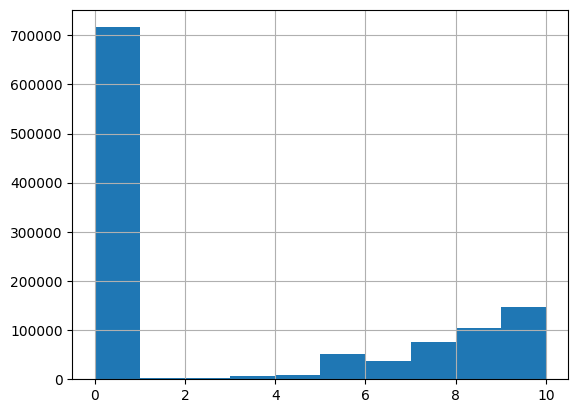

In [20]:
ratings['Book-Rating'].hist();

LOS VALOres con 0 no son generados por los usuarios -> nos los cargamos.

In [22]:
ratings[ratings['Book-Rating'] != 0]

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


# preparación de datos

In [23]:
res = (ratings.query('`Book-Rating` != 0'))# query permite hacer consultas sobre el dataframe una forma bastante efectiva para filtrar 😜
res

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


<AxesSubplot: >

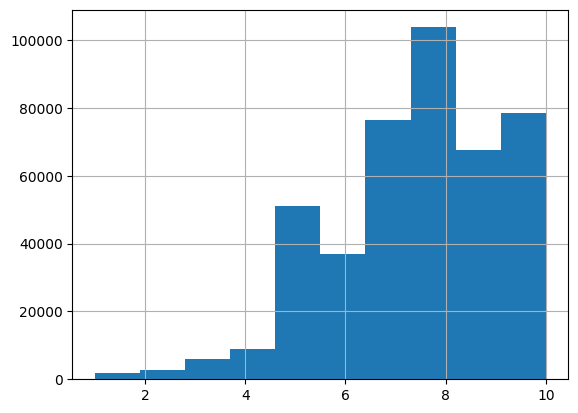

In [24]:
res['Book-Rating'].hist()

# Generación del sistema de recomendación

- generamos el objeto reader
- hacemos el dataframe concreto

In [30]:
from surprise import Dataset, Reader


reader = Reader(line_format='user item rating', rating_scale=(1, 10))
data = Dataset.load_from_df(res, reader)

entrenamos el modelo

In [31]:
from surprise import SVD

# generamos el conjunto de entrenamiento
data_train_surp = data.build_full_trainset()

# definimos el modelo LSA 
svd = SVD()

# entrenamos el modelo
svd.fit(data_train_surp)

In [32]:
from surprise import accuracy


# generamos el conjunto de test a partir del conjunto de entrenamiento 
data_test_surp = data_train_surp.build_testset() 

#data_test_surp = data_test_surp.construct_testset() 
predictions = svd.test(data_test_surp)

accuracy.rmse(predictions)

RMSE: 0.9867


0.9866534910375149

predecir movidas:

In [33]:
user_id = 276726
content_id = '0155061224'

svd.predict(user_id, content_id)

Prediction(uid=276726, iid='0155061224', r_ui=None, est=6.86031510901371, details={'was_impossible': False})

quiero hacer predicciones para libros que no se haya leído el sujeto.

In [36]:
ratings_pred = res.loc[res['User-ID'] == 276729]
ratings_pred

,User-ID,ISBN,Book-Rating
3,276729,052165615X,3
4,276729,0521795028,6


In [37]:
# obtener la lista de ID de películas 
unique_ids = res['ISBN'].unique()
unique_ids

array(['0155061224', '052165615X', '0521795028', ..., '0380796155',
       '0806917695', '05162443314'], dtype=object)

In [38]:
# obtener la lista de ID que ha visto el ID de usuario 13618 
iids1001 = res.loc[res['User-ID']==35859, 'ISBN']
iids1001

157178    0004722124
157188    0022749020
157190    0027426459
157191    0027434850
157192    0030018897
             ...    
163000    1885222041
163001    1885222769
163004    188602832X
163013    1887368256
163020    1929976011
Name: ISBN, Length: 829, dtype: object

In [39]:
# eliminar las películas calificadas para las recomendaciones 
books_to_predict = np.setdiff1d(unique_ids,iids1001)
books_to_predict

array([' 0330299891', ' 0375404120', ' 9022906116', ..., 'ooo7156103',
       '´3499128624', 'Ô½crosoft'], dtype=object)

In [45]:
my_recs = []
for iid in books_to_predict:
  my_recs.append((iid, svd.predict(uid=35859,iid=iid).est))
print(my_recs[-1])
pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values(by='predictions', ascending=False)#['predictions'].unique()


('Ô½crosoft', 6.956157538393279)


,iid,predictions
72812,0553274503,10.000000
80166,0609807900,10.000000
56344,0441790348,10.000000
57443,044651652X,10.000000
53780,0440211727,10.000000
...,...,...
26251,0316690619,4.711652
140352,1573229326,4.615722
58304,044661095X,4.468047
30724,034538475X,4.071306


los usuarios se han leido libros que el sujeto de estudio -- te recomienda los libros que les haya gustado a los usuarios y lo han puntuado igual.

In [41]:
len(my_recs)

185144

In [42]:
len(books_to_predict)

185144

In [46]:
import difflib
import random

def get_book_id(book_title, metadata):
    
    existing_titles = list(metadata['Book-Title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['Book-Title'] == closest_titles[0]]['id'].values[0]
    return book_id

def get_book_info(book_id, metadata):
    
    book_info = metadata[metadata['id'] == book_id][['id', 'isbn', 
                                                    'authors', 'Book-Title', 'original_title']]
    return book_info.to_dict(orient='records')

def predict_review(user_id, book_title, model, metadata):
    
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    book_titles = list(metadata['Book-Title'].values)
    random.shuffle(book_titles)
    
    for book_title in book_titles:
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
            book_id = get_book_id(book_title, metadata)
            return get_book_info(book_id, metadata)

In [47]:
books_metadata = pd.read_csv('data/BX-Books.csv', sep = ";", encoding='latin-1', on_bad_lines='skip')
books_metadata

/var/folders/m6/wtrz4vsj7cv881kk9kqh1v500000gn/T/ipykernel_48279/1462272093.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_metadata = pd.read_csv('data/BX-Books.csv', sep = ";", encoding='latin-1', on_bad_lines='skip')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...
